In [77]:
# 导入需要的包
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.metrics import explained_variance_score
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
import pandas as pd
import numpy as np
from sklearn import metrics
import csv
from sklearn.svm import SVR
import matplotlib.pyplot as plt 
from datetime import datetime 
from sklearn.metrics import mean_squared_error 
from sklearn import metrics
from sklearn.metrics import mean_absolute_error # 平方绝对误差
import random
import time
import copy

In [236]:
# 打开数据文件
df = pd.read_excel('D:\桌面\数据挖掘-汽油辛烷值损失模型优化\暑期模拟-3-2022-08-18\模拟练习-3 B题 汽油辛烷值建模\降维后特征.xlsx')
# 拆分成训练集和测试集，测试集大小为原始数据集大小的 2/10  (即训练集数为260)
df_train=df.loc[0:260,:]
df_test=df.loc[261:324,:]
y_train_1=df["RON损失\n（不是变量）"].loc[0:260]
y_test_1=df["RON损失\n（不是变量）"].loc[261:324]
y_train_2=df["硫含量,μg/g.1"].loc[0:260]
y_test_2=df["硫含量,μg/g.1"].loc[261:324]
df_train=df_train.copy()
df_test=df_test.copy()
x_train=df_train.drop(['RON损失\n（不是变量）','硫含量,μg/g.1'], axis=1)
x_test=df_test.drop(['RON损失\n（不是变量）','硫含量,μg/g.1'], axis=1)
# #将数据变成np.array的格式
x_train=np.array(x_train)
x_test=np.array(x_test)
y_train_2=np.array(y_train_2)
y_test_2=np.array(y_test_2)
y_train_1=np.array(y_train_1)
y_test_1=np.array(y_test_1)

In [223]:
scaler = StandardScaler() # 标准化转换
scaler.fit(x_train)  # 训练标准化对象
x_train= scaler.transform(x_train)   # 转换数据集
scaler.fit(x_test)  
x_test= scaler.transform(x_test)


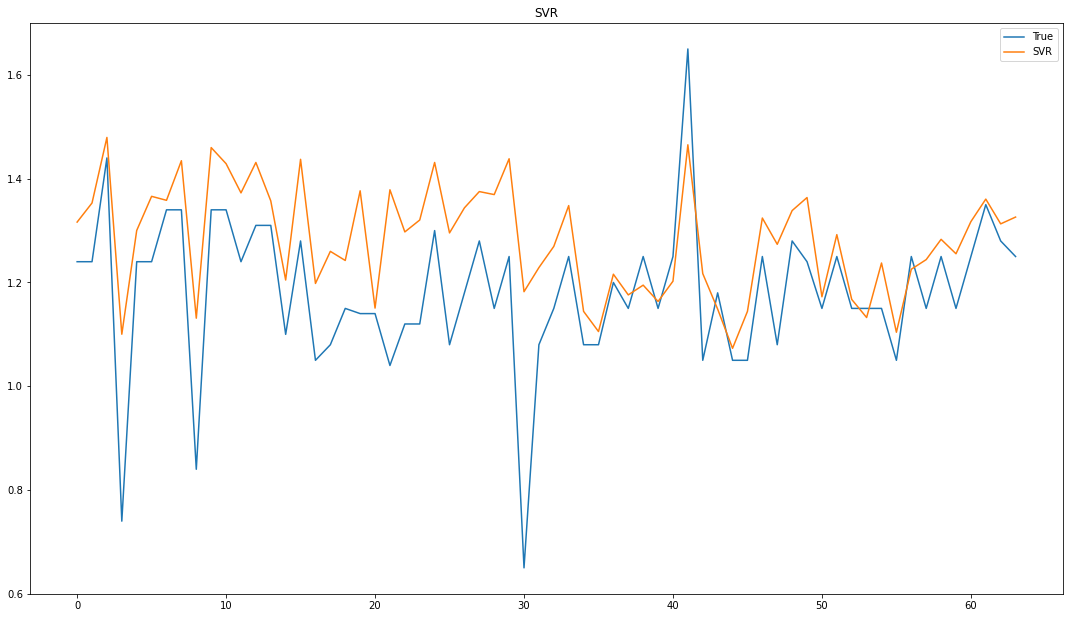

EVS: 0.46768007559870983
R2: -0.004305351748869812
Time: 0.03823590278625488


In [225]:
# SVR (辛烷值(RON)作为目标集)
start1=time.time()
model_svr = SVR()
model_svr.fit(x_train,y_train_1.ravel())
predict_results1=model_svr.predict(x_test)
end1=time.time()

plt.plot(y_test_1)#测试数组
plt.plot(predict_results1)#测试数组
plt.legend(['True','SVR'])
fig = plt.gcf()
fig.set_size_inches(18.5, 10.5)
plt.title("SVR")  # 标题
plt.show()
# 可释方差得分 (EVS) 解释变异（ Explained variance）是根据误差的方差计算得到. 最佳模型的可释方差分数值为1，模型越差值越小.
print("EVS:",explained_variance_score(y_test_1,predict_results1))                                                               
print("R2:",metrics.r2_score(y_test_1,predict_results1))
print("Time:",end1-start1)


In [219]:
# 使用GA算法对SVR进行调参

#设置适应度，这里设置为R2
def msefunc(predictval,realval):
    print("R2 = ",metrics.r2_score(realval,predictval)) # R2
    return metrics.r2_score(realval,predictval)

 #设置优化函数，这里为SVR，参数在此绑定，使用验证集输入验证得出适应度
def SVMResult(vardim, x, bound):
    X = x_train.tolist()
    y = y_train_1.ravel().tolist()
    c=x[0]
    e=x[1]
    g=x[2]
    clf = SVR(C=c,epsilon=e,gamma=g)
    clf.fit(X, y)
    predictval=clf.predict(x_test.tolist())
    return msefunc(predictval,y_test_1.tolist())

class GAIndividual:
 
    '''
    individual of genetic algorithm
    '''
 
    def __init__(self,  vardim, bound):
        '''
        vardim: dimension of variables
        bound: boundaries of variables
        '''
        self.vardim = vardim
        self.bound = bound
        self.fitness = 0.
 
    def generate(self):
        '''
        generate a random chromsome for genetic algorithm
        '''
        len = self.vardim
        rnd = np.random.random(size=len)
        self.chrom = np.zeros(len)
        for i in range(0, len):
            self.chrom[i] = self.bound[0, i] + \
                (self.bound[1, i] - self.bound[0, i]) * rnd[i]
 
    def calculateFitness(self):
        '''
        calculate the fitness of the chromsome
        '''
        self.fitness = SVMResult(self.vardim, self.chrom, self.bound)
        

 
class GeneticAlgorithm:
 
    '''
    The class for genetic algorithm
    '''
 
    def __init__(self, sizepop, vardim, bound, MAXGEN, params):
        '''
        sizepop: population sizepop人口规模
        vardim: dimension of variables变量维数
        bound: boundaries of variables变量边界
        MAXGEN: termination condition终止条件
        param: algorithm required parameters, it is a list which is consisting of crossover rate, mutation rate, alpha
        '''
        self.sizepop = sizepop
        self.MAXGEN = MAXGEN
        self.vardim = vardim
        self.bound = bound
        self.population = []
        self.fitness = np.zeros((self.sizepop, 1))
        self.trace = np.zeros((self.MAXGEN, 3))
        self.params = params
 
    def initialize(self):
        '''
        initialize the population
        '''
        for i in range(0, self.sizepop):
            ind = GAIndividual(self.vardim, self.bound)
            ind.generate()
            self.population.append(ind)
 
    def evaluate(self):
        '''
        evaluation of the population fitnesses
        '''
        for i in range(0, self.sizepop):
            self.population[i].calculateFitness()
            self.fitness[i] = self.population[i].fitness
 
    def solve(self):
        '''
        evolution process of genetic algorithm
        '''
        self.t = 0
        self.initialize()
        self.evaluate()
        best = np.max(self.fitness)
        bestIndex = np.argmax(self.fitness)
        self.best = copy.deepcopy(self.population[bestIndex])
        self.avefitness = np.mean(self.fitness)
        self.maxfitness = np.max(self.fitness)
        
        self.trace[self.t, 0] =  self.best.fitness
        self.trace[self.t, 1] =  self.avefitness
        self.trace[self.t, 2] =  self.maxfitness
        print("Generation %d: optimal function value is: %f; average function value is %f;max function value is %f"% (
            self.t, self.trace[self.t, 0], self.trace[self.t, 1],self.trace[self.t, 2]))
        while (self.t < self.MAXGEN - 1):
            self.t += 1
            self.selectionOperation()
            self.crossoverOperation()
            self.mutationOperation()
            self.evaluate()
            best = np.max(self.fitness)
            bestIndex = np.argmax(self.fitness)
            if best > self.best.fitness:
                self.best = copy.deepcopy(self.population[bestIndex])
            self.avefitness = np.mean(self.fitness)
            self.maxfitness = np.max(self.fitness)
            
            self.trace[self.t, 0] =  self.best.fitness
            self.trace[self.t, 1] = self.avefitness
            self.trace[self.t, 2] =  self.maxfitness
            print("Generation %d: optimal function value is: %f; average function value is %f;max function value is %f"% (
            self.t, self.trace[self.t, 0], self.trace[self.t, 1],self.trace[self.t, 2]))
 
        print("Optimal function value is: %f; " %
              self.trace[self.t, 0])
        print ("Optimal solution is:")
        print (self.best.chrom)
        self.printResult()
 
    def selectionOperation(self):
        '''
        selection operation for Genetic Algorithm
        '''
        newpop = []
        totalFitness = np.sum(self.fitness)
        accuFitness = np.zeros((self.sizepop, 1))
 
        sum1 = 0.
        for i in range(0, self.sizepop):
            accuFitness[i] = sum1 + self.fitness[i] / totalFitness
            sum1 = accuFitness[i]
 
        for i in range(0, self.sizepop):
            r = random.random()
            idx = 0
            for j in range(0, self.sizepop - 1):
                if j == 0 and r < accuFitness[j]:
                    idx = 0
                    break
                elif r >= accuFitness[j] and r < accuFitness[j + 1]:
                    idx = j + 1
                    break
            newpop.append(self.population[idx])
        self.population = newpop
 
    def crossoverOperation(self):
        '''
        crossover operation for genetic algorithm
        '''
        newpop = []
        for i in range(0, self.sizepop, 2):
            idx1 = random.randint(0, self.sizepop - 1)
            idx2 = random.randint(0, self.sizepop - 1)
            while idx2 == idx1:
                idx2 = random.randint(0, self.sizepop - 1)
            newpop.append(copy.deepcopy(self.population[idx1]))
            newpop.append(copy.deepcopy(self.population[idx2]))
            r = random.random()
            if r < self.params[0]:
                crossPos = random.randint(1, self.vardim - 1)
                for j in range(crossPos, self.vardim):
                    newpop[i].chrom[j] = newpop[i].chrom[
                        j] * self.params[2] + (1 - self.params[2]) * newpop[i + 1].chrom[j]
                    newpop[i + 1].chrom[j] = newpop[i + 1].chrom[j] * self.params[2] + \
                        (1 - self.params[2]) * newpop[i].chrom[j]
        self.population = newpop
 
    def mutationOperation(self):
        '''
        mutation operation for genetic algorithm
        '''
        newpop = []
        for i in range(0, self.sizepop):
            newpop.append(copy.deepcopy(self.population[i]))
            r = random.random()
            if r < self.params[1]:
                mutatePos = random.randint(0, self.vardim - 1)
                theta = random.random()
                if theta > 0.5:
                    newpop[i].chrom[mutatePos] = newpop[i].chrom[
                        mutatePos] - (newpop[i].chrom[mutatePos] - self.bound[0, mutatePos]) * (1 - random.random() ** (1 - self.t / self.MAXGEN))
                else:
                    newpop[i].chrom[mutatePos] = newpop[i].chrom[
                        mutatePos] + (self.bound[1, mutatePos] - newpop[i].chrom[mutatePos]) * (1 - random.random() ** (1 - self.t / self.MAXGEN))
        self.population = newpop
 
    def printResult(self):
        '''
        plot the result of the genetic algorithm
        '''
        x = np.arange(0, self.MAXGEN)
        y1 = self.trace[:, 0]
        y2 = self.trace[:, 1]
        y3 = self.trace[:, 2]
        #plt.plot(x, y1, 'r', label='optimal value')
        plt.plot(x, y2, 'g', label='average value')
        plt.plot(x, y3, 'b', label='max value')
        fig = plt.gcf()
        fig.set_size_inches(18.5, 10.5)
        plt.xlabel("GENS")
        plt.ylabel("R2")
        plt.title("GA")
        plt.legend()
        plt.show()       


R2 =  -1.3828234253177252
R2 =  -0.5058777830704366
R2 =  -1.3828234253177252
R2 =  -1.3828234253177252
R2 =  -1.3828234253177252
R2 =  -1.3828234253177252
R2 =  -0.26590390772578765
R2 =  -1.3828234253177252
R2 =  -1.3828234253177252
R2 =  -1.3828234253177252
Generation 0: optimal function value is: -0.265904; average function value is -1.183437;max function value is -0.265904
R2 =  -1.3828234253177252
R2 =  -1.3828234253177252
R2 =  -1.3828234253177252
R2 =  -1.3828234253177252
R2 =  -1.3828234253177252
R2 =  -1.3828234253177252
R2 =  -1.3828234253177252
R2 =  -1.3828234253177252
R2 =  -1.3828234253177252
R2 =  -1.3828234253177252
Generation 1: optimal function value is: -0.265904; average function value is -1.382823;max function value is -1.382823
R2 =  -1.3828234253177252
R2 =  -1.3828234253177252
R2 =  -1.3828234253177252
R2 =  -1.3828234253177252
R2 =  -1.3828234253177252
R2 =  -1.3828234253177252
R2 =  -1.3828234253177252
R2 =  -1.3828234253177252
R2 =  -1.3828234253177252
R2 = 

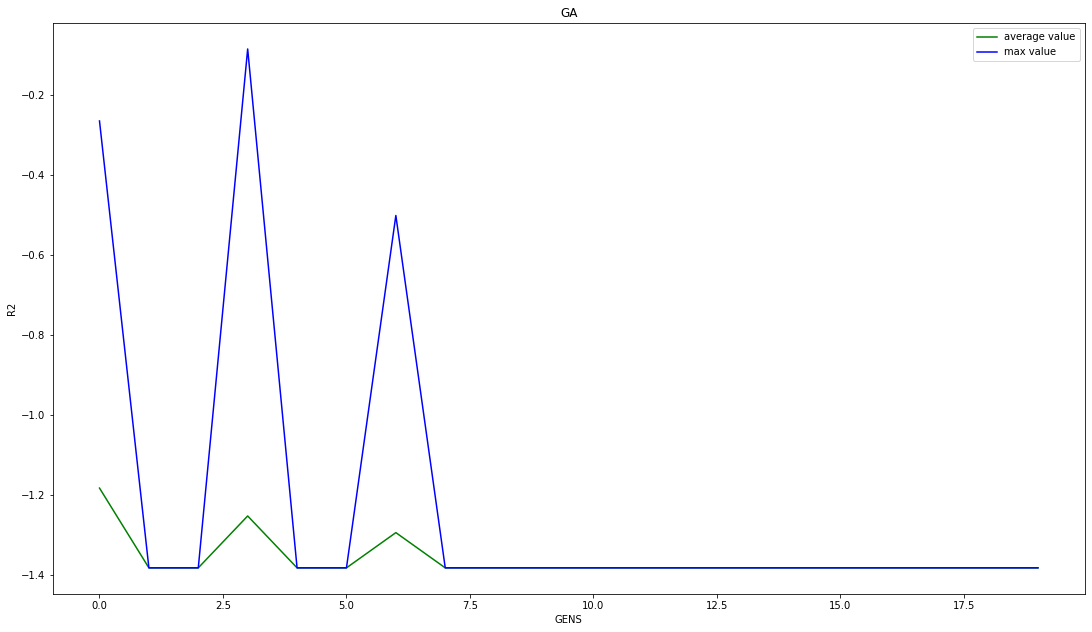

In [226]:
if __name__ == "__main__":
   bound = np.array([[0,0,0],[10,2,100]])
   ga = GeneticAlgorithm(10, 3, bound, 20, [0.9, 0.1, 0.5])
   ga.solve()


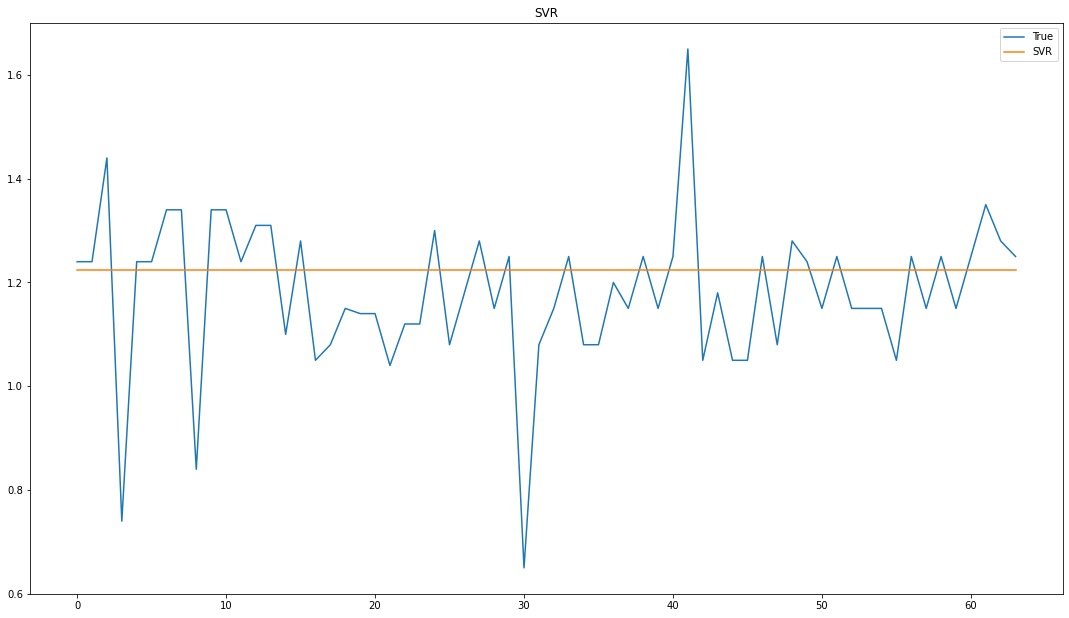

EVS: -2.220446049250313e-16
R2: -0.08595137448472845
Time: 0.00719904899597168


In [233]:
# 融合GA-SVR模型
start1=time.time()
model_svr = SVR(C=6.43237994,epsilon=0.44678642,gamma=77.10107946)
model_svr.fit(x_train,y_train_1.ravel())
predict_results1=model_svr.predict(x_test)
end1=time.time()

plt.plot(y_test_1)#测试数组
plt.plot(predict_results1)#测试数组
plt.legend(['True','SVR'])
fig = plt.gcf()
fig.set_size_inches(18.5, 10.5)
plt.title("SVR")  # 标题
plt.show()
print("EVS:",explained_variance_score(y_test_1,predict_results1))
print("R2:",metrics.r2_score(y_test_1,predict_results1))
print("Time:",end1-start1)

In [ ]:
## 通过上图可知，GA算法优化结果非常容易陷入局部最优
# 利用粒子群算法（PSO）来优化SVR

In [234]:
class PSO:
    def __init__(self, parameters):
        """
        particle swarm optimization
        parameter: a list type, like [NGEN, pop_size, var_num_min, var_num_max]
        """
        # 初始化
        self.NGEN = parameters[0]    # 迭代的代数
        self.pop_size = parameters[1]    # 种群大小
        self.var_num = len(parameters[2])     # 变量个数
        self.bound = []                 # 变量的约束范围
        self.bound.append(parameters[2])
        self.bound.append(parameters[3])
 
        self.pop_x = np.zeros((self.pop_size, self.var_num))    # 所有粒子的位置
        self.pop_v = np.zeros((self.pop_size, self.var_num))    # 所有粒子的速度
        self.p_best = np.zeros((self.pop_size, self.var_num))   # 每个粒子最优的位置
        self.g_best = np.zeros((1, self.var_num))   # 全局最优的位置
 
        # 初始化第0代初始全局最优解
        temp = -1
        for i in range(self.pop_size):
            for j in range(self.var_num):
                self.pop_x[i][j] = random.uniform(self.bound[0][j], self.bound[1][j])
                self.pop_v[i][j] = random.uniform(0, 1)
            self.p_best[i] = self.pop_x[i]      # 储存最优的个体
            fit = self.fitness(self.p_best[i])
            if fit > temp:
                self.g_best = self.p_best[i]
                temp = fit
 
    def fitness(self, ind_var):
        X = x_train
        y = y_train_1
        """
        个体适应值计算
        """
        x1 = ind_var[0]
        x2 = ind_var[1]
        x3 = ind_var[2]
        
        if x1==0:x1=0.001
        if x2==0:x2=0.001
        if x3==0:x3=0.001
            
        clf = SVR(C=x1,epsilon=x2,gamma=x3)
        clf.fit(X, y.ravel())
        predictval=clf.predict(x_test)
        print("R2 = ",metrics.r2_score(y_test_1,predictval)) # R2
        return  metrics.r2_score(y_test_1,predictval)
 
    def update_operator(self, pop_size):
        """
        更新算子：更新下一时刻的位置和速度
        """
        c1 = 2     # 学习因子，一般为2
        c2 = 2
        w = 0.4    # 自身权重因子
        for i in range(pop_size):
            # 更新速度
            self.pop_v[i] = w * self.pop_v[i] + c1 * random.uniform(0, 1) * (
                        self.p_best[i] - self.pop_x[i]) + c2 * random.uniform(0, 1) * (self.g_best - self.pop_x[i])
            # 更新位置
            self.pop_x[i] = self.pop_x[i] + self.pop_v[i]
            # 越界保护
            for j in range(self.var_num):
                if self.pop_x[i][j] < self.bound[0][j]:
                    self.pop_x[i][j] = self.bound[0][j]
                if self.pop_x[i][j] > self.bound[1][j]:
                    self.pop_x[i][j] = self.bound[1][j]
            # 更新p_best和g_best
            if self.fitness(self.pop_x[i]) > self.fitness(self.p_best[i]):
                self.p_best[i] = self.pop_x[i]
            if self.fitness(self.pop_x[i]) > self.fitness(self.g_best):
                self.g_best = self.pop_x[i]
 
    def main(self):
        popobj = []
        self.ng_best = np.zeros((1, self.var_num))[0]
        for gen in range(self.NGEN):
            self.update_operator(self.pop_size)
            popobj.append(self.fitness(self.g_best))
            print('############ Generation {} ############'.format(str(gen + 1)))
            if self.fitness(self.g_best) > self.fitness(self.ng_best):
                self.ng_best = self.g_best.copy()
            print('最好的位置：{}'.format(self.ng_best))
            print('最大的函数值：{}'.format(self.fitness(self.ng_best)))
        print("---- End of (successful) Searching ----")
 
        plt.figure()
        fig = plt.gcf()
        fig.set_size_inches(18.5, 10.5)
        plt.title("Figure1")
        plt.xlabel("iterators", size=14)
        plt.ylabel("fitness", size=14)
        t = [t for t in range(self.NGEN)]
        plt.plot(t, popobj, color='b', linewidth=2)
        plt.show()


R2 =  -0.1995447695672603
R2 =  -0.33703987477314445
R2 =  -1.3828234253177252
R2 =  -0.11168348401808958
R2 =  -0.5057283786411888
R2 =  -1.3828234253177252
R2 =  -1.3828234253177252
R2 =  -1.3828234253177252
R2 =  -1.3828234253177252
R2 =  -1.3828234253177252
R2 =  -1.3828234253177252
R2 =  -1.3828234253177252
R2 =  -1.3828234253177252
R2 =  -1.3828234253177252
R2 =  -1.3828234253177252
R2 =  -0.026977497150427743
R2 =  -1.3828234253177252
R2 =  -0.13248236794935964
R2 =  -1.3828234253177252
R2 =  -1.3828234253177252
R2 =  -0.6444253214897702
R2 =  -0.1995447695672603
R2 =  -0.6444253214897702
R2 =  -0.026977497150427743
R2 =  -1.3828234253177252
R2 =  -0.33703987477314445
R2 =  -1.3828234253177252
R2 =  -0.026977497150427743
R2 =  -0.13907218502398977
R2 =  -1.3828234253177252
R2 =  -0.13907218502398977
R2 =  -0.026977497150427743
R2 =  -1.3828234253177252
R2 =  -0.11168348401808958
R2 =  -1.3828234253177252
R2 =  -0.026977497150427743
R2 =  -1.3828234253177252
R2 =  -0.505728378641

R2 =  -6.610745667789963e-05
R2 =  -0.32114670355260677
R2 =  -0.3936733088230746
R2 =  -0.32114670355260677
R2 =  -6.610745667789963e-05
R2 =  -1.3828234253177252
R2 =  -0.19831749091795614
R2 =  -1.3828234253177252
R2 =  -6.610745667789963e-05
R2 =  -1.3828234253177252
R2 =  -1.3828234253177252
R2 =  -1.3828234253177252
R2 =  -6.610745667789963e-05
R2 =  -1.3828234253177252
R2 =  -0.22049698255065953
R2 =  -1.3828234253177252
R2 =  -6.610745667789963e-05
R2 =  -1.3828234253177252
R2 =  -0.0018359083664740705
R2 =  -1.3828234253177252
R2 =  -6.610745667789963e-05
R2 =  -0.36140898377318087
R2 =  -1.3828234253177252
R2 =  -0.36140898377318087
R2 =  -6.610745667789963e-05
R2 =  -0.0033543826415436406
R2 =  -0.10055738451719076
R2 =  -0.0033543826415436406
R2 =  -6.610745667789963e-05
R2 =  -0.44370668367324195
R2 =  -1.3828234253177252
R2 =  -0.44370668367324195
R2 =  -6.610745667789963e-05
R2 =  -0.09828787891542334
R2 =  -0.008845739633066785
R2 =  -0.09828787891542334
R2 =  -6.610745

R2 =  -0.3962203016132604
R2 =  -0.00023054168766267757
R2 =  -0.5051036765086301
R2 =  -0.3926845265307992
R2 =  -0.5051036765086301
R2 =  -0.00023054168766267757
R2 =  -0.00023054168766267757
############ Generation 7 ############
R2 =  -0.00023054168766267757
R2 =  -6.6162981993134196e-06
最好的位置：[ 4.12940462  0.53643764 38.37034502]
R2 =  -6.6162981993134196e-06
最大的函数值：-6.6162981993134196e-06
R2 =  -0.01735019728722631
R2 =  -0.017080817079454302
R2 =  -0.01735019728722631
R2 =  -0.00023054168766267757
R2 =  -0.009562298510394918
R2 =  -0.025758082062395937
R2 =  -0.009562298510394918
R2 =  -0.00023054168766267757
R2 =  -0.020510806379878233
R2 =  -6.610745667789963e-05
R2 =  -0.020510806379878233
R2 =  -0.00023054168766267757
R2 =  -0.15025509381740343
R2 =  -0.030731818684271994
R2 =  -0.15025509381740343
R2 =  -0.00023054168766267757
R2 =  -0.20231796241430033
R2 =  -0.11212595936418435
R2 =  -0.20231796241430033
R2 =  -0.00023054168766267757
R2 =  -0.50560067262221
R2 =  -0.03420

R2 =  -0.050392292810813144
R2 =  -0.001661571194880862
R2 =  -0.07048047465844576
R2 =  -0.05747855985672956
R2 =  -0.07048047465844576
R2 =  -0.001661571194880862
R2 =  -0.00818928440043587
R2 =  -0.0022634920246842327
R2 =  -0.00818928440043587
R2 =  -0.001661571194880862
R2 =  -0.8672978829154174
R2 =  -0.19831749091795614
R2 =  -0.8672978829154174
R2 =  -0.001661571194880862
R2 =  -1.151174150208786
R2 =  -0.36140898377318087
R2 =  -1.151174150208786
R2 =  -0.001661571194880862
R2 =  -0.001750771358760117
R2 =  -0.02811797257488502
R2 =  -0.001750771358760117
R2 =  -0.001661571194880862
R2 =  -0.35333455126093427
R2 =  -0.0018359083664740705
R2 =  -0.35333455126093427
R2 =  -0.001661571194880862
R2 =  -0.027152141961560794
R2 =  -0.008442158197183858
R2 =  -0.027152141961560794
R2 =  -0.001661571194880862
R2 =  -0.4223339786891187
R2 =  -0.0033543826415436406
R2 =  -0.4223339786891187
R2 =  -0.001661571194880862
R2 =  -0.07065472644511805
R2 =  -0.39268510551121394
R2 =  -0.070654

R2 =  -1.844059204092474e-05
R2 =  -0.48355896238421203
R2 =  -0.0033543826415436406
R2 =  -0.48355896238421203
R2 =  -1.844059204092474e-05
R2 =  -0.018183168696697782
R2 =  -0.009404899611384243
R2 =  -0.018183168696697782
R2 =  -1.844059204092474e-05
R2 =  -2.9231817587405118e-05
R2 =  -0.00023054168766267757
R2 =  -2.9231817587405118e-05
R2 =  -1.844059204092474e-05
R2 =  -0.0004639541855089302
R2 =  -0.0013904665830892782
R2 =  -0.0004639541855089302
R2 =  -1.844059204092474e-05
R2 =  -1.2924247779766418e-05
R2 =  -6.6162981993134196e-06
R2 =  -1.2924247779766418e-05
R2 =  -1.2924247779766418e-05
R2 =  -0.0003915466342911955
R2 =  -0.0004091571399980065
R2 =  -0.0003915466342911955
R2 =  -1.2924247779766418e-05
R2 =  -0.028679496057936626
R2 =  -0.003165119201562483
R2 =  -0.028679496057936626
R2 =  -1.2924247779766418e-05
R2 =  -1.2924247779766418e-05
############ Generation 14 ############
R2 =  -1.2924247779766418e-05
R2 =  -6.6162981993134196e-06
最好的位置：[ 4.12940462  0.53643764

R2 =  -0.004508909461985011
R2 =  -0.0002058324060045802
R2 =  -0.004508909461985011
R2 =  -9.252111307977984e-05
R2 =  -2.6349556281779485e-05
R2 =  -3.5510119249515526e-06
R2 =  -2.6349556281779485e-05
R2 =  -9.252111307977984e-05
R2 =  -0.012431462815231997
R2 =  -0.0003735626201843978
R2 =  -0.012431462815231997
R2 =  -2.6349556281779485e-05
R2 =  -0.0007603176112236376
R2 =  -5.123989716970812e-07
R2 =  -0.0007603176112236376
R2 =  -2.6349556281779485e-05
R2 =  -0.00140828590790254
R2 =  -3.3711339188169376e-05
R2 =  -0.00140828590790254
R2 =  -2.6349556281779485e-05
R2 =  -0.002481701244168244
R2 =  -0.001102340564645088
R2 =  -0.002481701244168244
R2 =  -2.6349556281779485e-05
R2 =  -0.0003698767394444413
R2 =  -8.770747562891756e-05
R2 =  -0.0003698767394444413
R2 =  -2.6349556281779485e-05
R2 =  -0.15140735493531987
R2 =  -0.00035404276366235443
R2 =  -0.15140735493531987
R2 =  -2.6349556281779485e-05
R2 =  -0.0076577243170983245
R2 =  -0.0024397787592962406
R2 =  -0.007657724

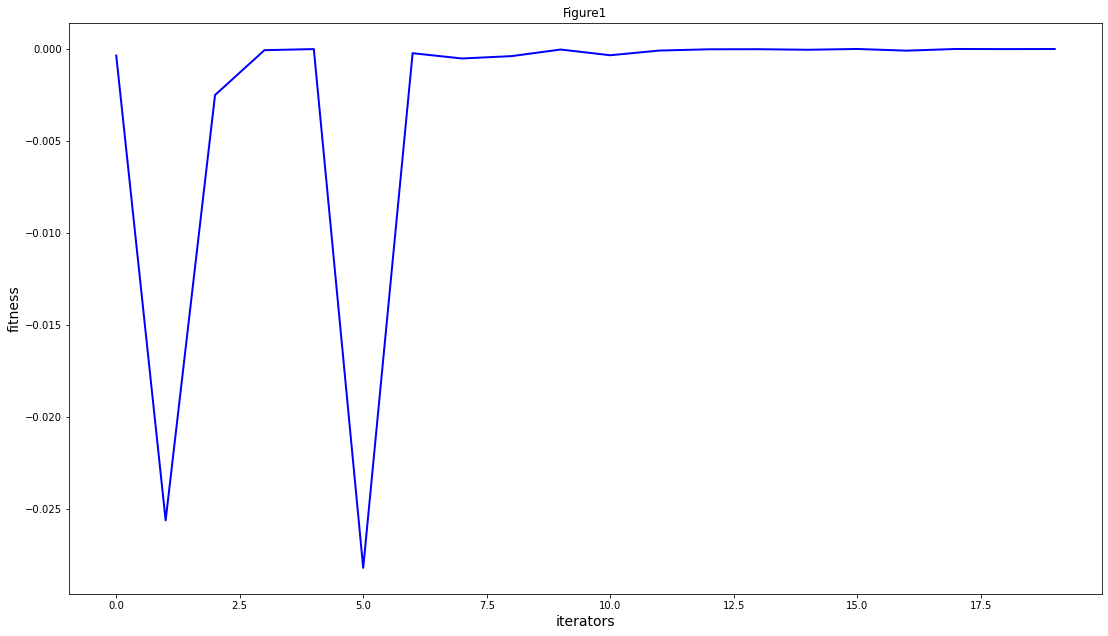

In [192]:
if __name__ == '__main__':
    NGEN = 20
    popsize = 20
    low = [0,0,0]
    up = [10,5,100]
    parameters = [NGEN, popsize, low, up]
    pso = PSO(parameters)
    pso.main()


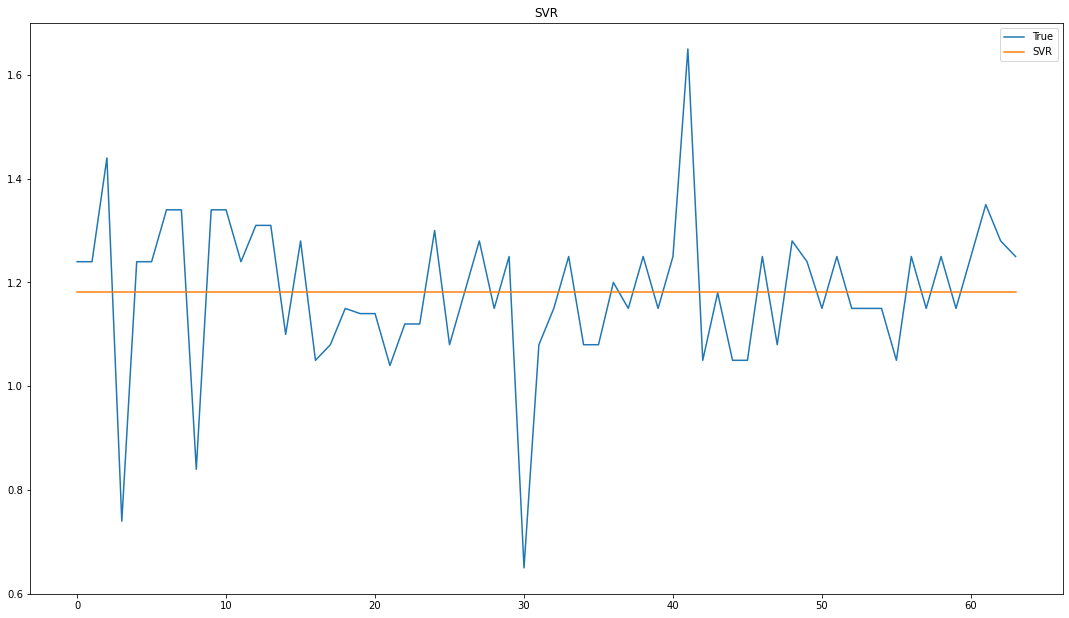

MSE: 0.021246462489016
R2 =  -1.189882177232704e-07
MAE =  0.10488612406250089


In [235]:
# 融合PSO-SVR模型
# model_svr = SVR()
model_svr = SVR(C=3.28357219,epsilon=0.53728806,gamma= 38.08638019)
model_svr.fit(x_train,y_train_1.ravel())
predict_results=model_svr.predict(x_test)
plt.plot(y_test_1)#测试数组
plt.plot(predict_results)#测试数组
plt.legend(['True','SVR'])
fig = plt.gcf()
fig.set_size_inches(18.5, 10.5)
plt.title("SVR")  # 标题
plt.show()
print("MSE:",mean_squared_error(y_test_1,predict_results))
print("R2 = ",metrics.r2_score(y_test_1,predict_results)) # R2
print("MAE = ",mean_absolute_error(y_test_1,predict_results))
